In [1]:
# %pip install patsy

In [2]:
import patsy as ps
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.linear_model import LinearRegression

df = pd.read_csv("./../birthdays.csv")

def clean_data(dataf):
    return (dataf
            .assign(date = lambda d: pd.to_datetime(d['date']))
            .groupby(['date', 'wday', 'month'])
            .agg(n_born=('births', 'sum'))
            .reset_index()
            .assign(yday = lambda d: d['date'].dt.dayofyear))

df_clean = df.pipe(clean_data)

In [3]:
df_clean.head(10)

,date,wday,month,n_born,yday
0,1969-01-01,Wed,1,8486,1
1,1969-01-02,Thurs,1,9002,2
2,1969-01-03,Fri,1,9542,3
3,1969-01-04,Sat,1,8960,4
4,1969-01-05,Sun,1,8390,5
5,1969-01-06,Mon,1,9560,6
6,1969-01-07,Tues,1,9738,7
7,1969-01-08,Wed,1,9734,8
8,1969-01-09,Thurs,1,9434,9
9,1969-01-10,Fri,1,10042,10


In [4]:

df_ml = df_clean.head(400)
y, X = ps.dmatrices("n_born ~ wday + yday - 1 + C(month)", df_ml)
print(X[:5])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]]


In [5]:
X

DesignMatrix with shape (400, 19)
  Columns:
    ['wday[Fri]',
     'wday[Mon]',
     'wday[Sat]',
     'wday[Sun]',
     'wday[Thurs]',
     'wday[Tues]',
     'wday[Wed]',
     'C(month)[T.2]',
     'C(month)[T.3]',
     'C(month)[T.4]',
     'C(month)[T.5]',
     'C(month)[T.6]',
     'C(month)[T.7]',
     'C(month)[T.8]',
     'C(month)[T.9]',
     'C(month)[T.10]',
     'C(month)[T.11]',
     'C(month)[T.12]',
     'yday']
  Terms:
    'wday' (columns 0:7)
    'C(month)' (columns 7:18)
    'yday' (column 18)
  (to view full data, use np.asarray(this_obj))

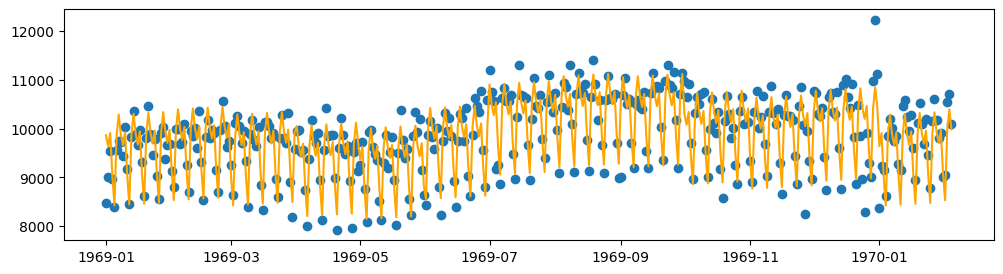

In [6]:
mod = LinearRegression().fit(X, y)

plt.figure(figsize=(12, 3))
plt.scatter(df_ml['date'], y)
plt.plot(df_ml['date'], mod.predict(X), color='orange');

In [7]:
# any python function

def date_to_num(date_col):
    return (date_col - date_col.min()).dt.days

y, X = ps.dmatrices("n_born ~ date_to_num(date) * np.log(yday)", df_ml)
display(X)

DesignMatrix with shape (400, 4)
  Intercept  date_to_num(date)  np.log(yday)  date_to_num(date):np.log(yday)
          1                  0       0.00000                         0.00000
          1                  1       0.69315                         0.69315
          1                  2       1.09861                         2.19722
          1                  3       1.38629                         4.15888
          1                  4       1.60944                         6.43775
          1                  5       1.79176                         8.95880
          1                  6       1.94591                        11.67546
          1                  7       2.07944                        14.55609
          1                  8       2.19722                        17.57780
          1                  9       2.30259                        20.72327
          1                 10       2.39790                        23.97895
          1                 11       2.4849

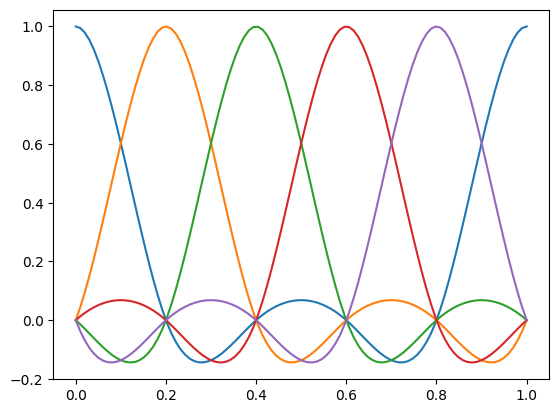

In [8]:
# spline features

x = np.linspace(0.0, 1.0, 100)
x_mat = ps.dmatrix("cc(x, df=5) - 1", pd.DataFrame({"x": x}))
plt.plot(x, x_mat);

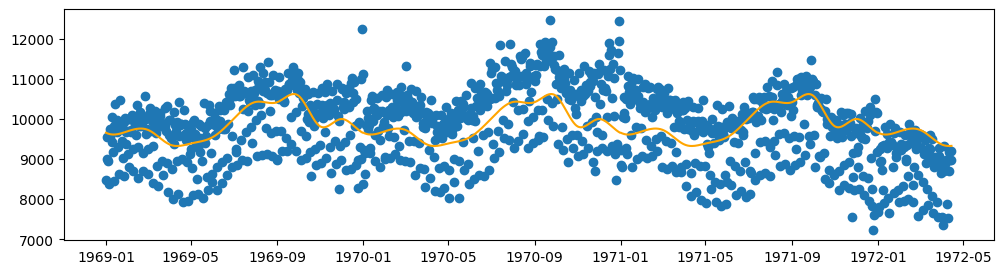

In [9]:
df_ml = df_clean.head(1200).loc[lambda d: d['n_born'] > 2000]
y, X = ps.dmatrices("n_born ~ cc(yday, df=12)", df_ml)
mod = LinearRegression().fit(X, y)

plt.figure(figsize=(12, 3))
plt.scatter(df_ml['date'], y)
plt.plot(df_ml['date'], mod.predict(X), color='orange');

In [10]:
def plot_model(mod, df, X, y):
    plt.figure(figsize=(12, 4))
    df_ml = df.copy().assign(pred = mod.predict(X))
    for day in 'Mon,Tues,Wed,Thurs,Fri,Sat,Sun'.split(','):
        df_subset = df_ml.loc[lambda d: d['wday'] == day]
        plt.scatter(df_subset['date'], df_subset['n_born'], color='steelblue')
        plt.plot(df_subset['date'], df_subset['pred'], label=day, linewidth=2)
    plt.legend()
    plt.title(f"mean absolute error = {np.mean(np.abs(mod.predict(X) - y))}");

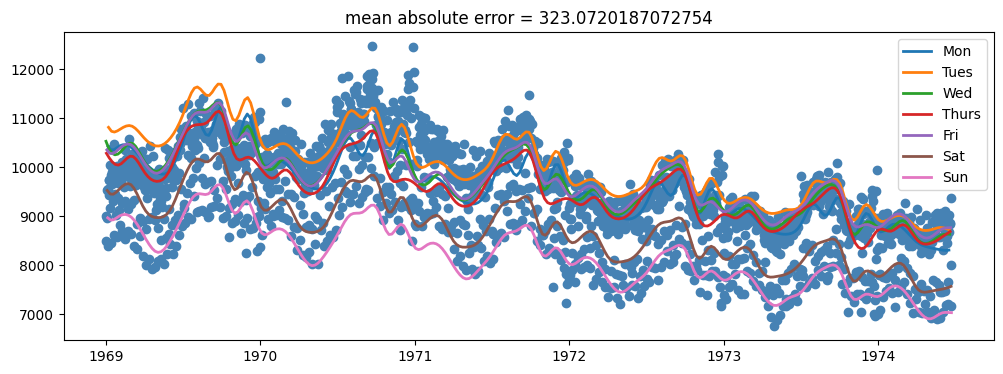

In [11]:
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt

df_ml = df_clean.head(2000).loc[lambda d: d['n_born'] > 2000]
y, X = ps.dmatrices("n_born ~ (cc(yday, df=12) + wday + date_to_num(date))**2", df_ml)
mod = LinearRegression().fit(X, y)
plot_model(mod, df_ml, X, y)

In [12]:
# all in all

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklego.preprocessing import PatsyTransformer

In [14]:
X = (df_clean
    .head(2000)
    .loc[lambda d: d['n_born'] > 2000]
    .assign(num_date = lambda d: date_to_num(d['date'])))
y = X['n_born']

pipe = Pipeline([
    ("patsy", PatsyTransformer("(cc(yday, df=12) + wday + num_date)**2")),
    ("scale", StandardScaler()),
    ("model", LinearRegression())
])

np.mean(np.abs(pipe.fit(X, y).predict(X) - y))

402.8698763218702